# Description
---

This notebook can be used to reproduce results form the paper:
"Cross-column DFT-based QSRR model development powered by Machine Learning".

Data (molecular descriptors, column characteristics, and experimental retention times) are loaded, split into training, validation and blind test. QSRR models are built using four ML methods (Ridge Regression, Partial Least Squares, Random Forests and Gradient Boosting). Hyperparameters of the ML QSRR models are optimized using a grid search.

# Requirements
---

1. jupyter
2. notebook
3. numpy
4. pandas
5. matplotlib
6. seaborn
7. scikit-learn
8. shap

# Imports
---

In [1]:
# Install requirements
%pip install numpy pandas matplotlib seaborn scikit-learn shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%load_ext autoreload
%autoreload 2

from typing import (
    Any,
    Dict,
    List
)

import numpy as np
from numpy import ndarray

import pandas as pd
from pandas import DataFrame

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    cross_val_score,
    KFold,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    PredefinedSplit,
    train_test_split
)

from src.analysis import analyze_model
from src.config import (
    plot_settings,
    split_indices
)
from src.visuals import Visualizer

plt.rcParams.update(plot_settings)

sns.set()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Loading & Processing
---

In [3]:
# Load Data
_data_df: DataFrame = pd.read_csv(
    './data/2023-07-19-qsrr_dataset.csv'
)

# Drop columns= 'name' and '#', 'ID', "Length"
_data_df.drop(
    columns=['#','name', 'ID', "Length"],
    errors="ignore",
    inplace=True
)

# Display Data
display(_data_df.head())

,SE[kcal/mol],Delta(min)[eV],M(tot.)[D],EnergyGap[eV],Electrophilicity[eV],IP[eV],EA[eV],GlobalHardness[eV],Electronegativity[eV],Electrophilicity [eV],Temperature,Gradient,ParticleSize,Carbon Load,PoreSize,TR
0,-7.440,-0.503,5.3780,8.383,-3.93,8.12,-0.26,4.19,3.93,1.84,25,40,2.7,10,120,15.842
1,-6.145,-0.545,1.7540,7.810,-3.61,7.51,-0.30,3.90,3.61,1.67,25,40,2.7,10,120,30.996
2,-7.669,-0.679,2.4686,8.287,-3.68,7.82,-0.46,4.14,3.68,1.63,25,40,2.7,10,120,12.111
3,-9.395,-0.666,6.9915,9.167,-4.07,8.65,-0.52,4.58,4.07,1.81,25,40,2.7,10,120,4.968
4,-12.792,-0.680,3.8255,7.723,-2.63,6.49,-1.23,3.86,2.63,0.90,25,40,2.7,10,120,12.465


# Data Analysis
---

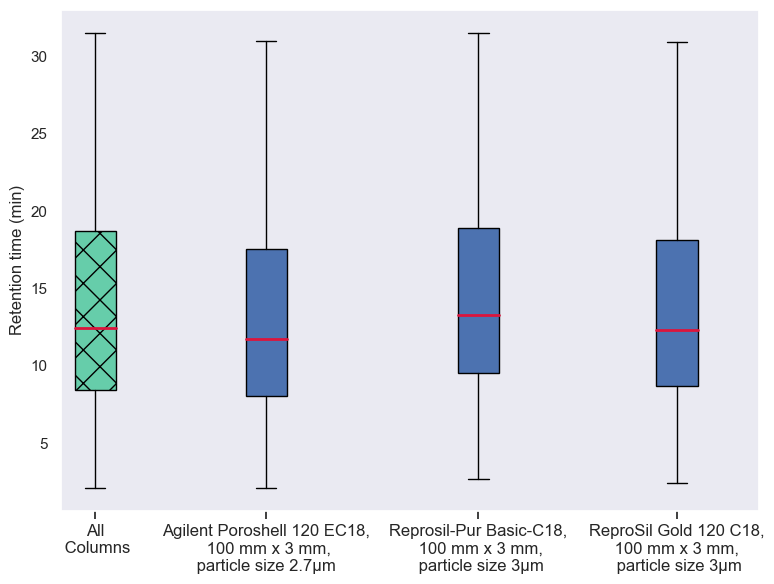

In [4]:
# Retention Times Boxplot

_x: List[Any] = [
    _data_df['TR'],
    _data_df['TR'][_data_df['Carbon Load'] == 10],  # Column 1
    _data_df['TR'][_data_df['Carbon Load'] == 17],  # Column 2
    _data_df['TR'][_data_df['Carbon Load'] == 20]
]

_positions: List[int] = [5, 30, 61, 90]

_labels: List[str] = [
    'All\n Columns',
    'Agilent Poroshell 120 EC18,\n 100 mm x 3 mm,\n particle size 2.7μm ',
    'Reprosil-Pur Basic-C18,\n 100 mm x 3 mm,\n particle size 3μm',
    'ReproSil Gold 120 C18,\n 100 mm x 3 mm, \n particle size 3μm'
]

_y_label: str = 'Retention time (min)'

Visualizer.boxplot(
    x=_x,
    positions=_positions,
    labels=_labels,
    y_label=_y_label
)

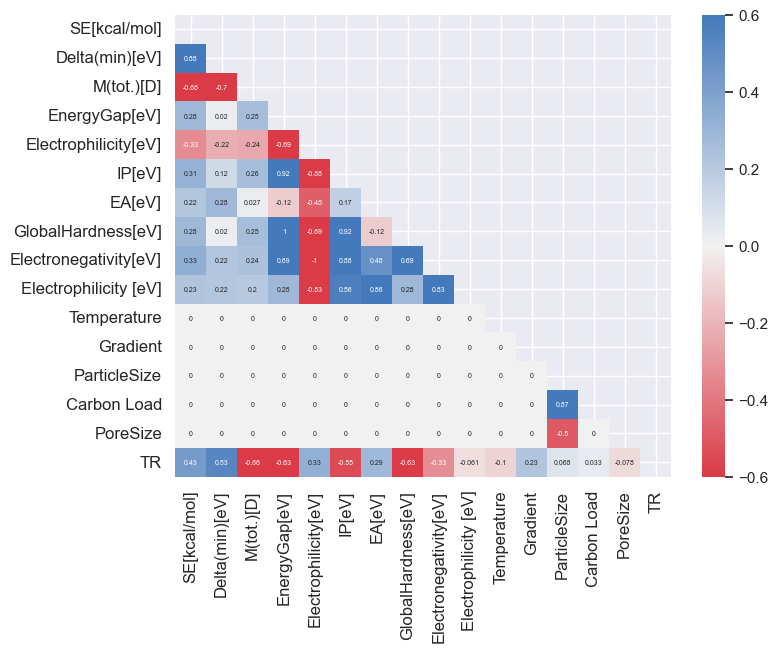

In [5]:
# Correlation Matrix Plot
_correlation_df = _data_df.corr(method='spearman')

Visualizer.correlation_heatmap(
    _correlation_df
)

# Train/Test Split

In [6]:
# X- and y- data
_x: ndarray = _data_df.iloc[:,:-1].values  # Variables -> x1 to x15
_y: ndarray = _data_df.iloc[:,-1].values   # Target: -> tR : retention tiime

# Split initial data into training & blind test sets
_x_train_all, _x_bt, _y_train_all, _y_bt = train_test_split(
    _x,
    _y,
    test_size=0.3
    ,shuffle=True,
    random_state=12345  # For reproducibility
)

# Split the training data further into training and validation
_x_train, _x_validation, _y_train, _y_validation = train_test_split(
    _x_train_all,
    _y_train_all,
    test_size=0.3,
    random_state=12345   # For reproducibility
)

# Summary
print('X-train:', _x_train.shape)
print('y-train:', _y_train.shape)
print('- - '*10)
print('X-validation:', _x_validation.shape)
print('y-validation:', _y_validation.shape)
print('- - '*10)
print('X-BT:', _x_bt.shape)
print('y-BT:', _y_bt.shape)
print('- - '*10)

# Using Predefiend Set of data for validation for hyper-parameter optimization
ps = PredefinedSplit(test_fold=split_indices)

X-train: (176, 15)
y-train: (176,)
- - - - - - - - - - - - - - - - - - - - 
X-validation: (76, 15)
y-validation: (76,)
- - - - - - - - - - - - - - - - - - - - 
X-BT: (108, 15)
y-BT: (108,)
- - - - - - - - - - - - - - - - - - - - 


# Hyper-Parameter Optimization, QSRR model building & analysis
---

## Random Forests
---

In [7]:
# RFs parameter grid
_rfs_param_grid: Dict[str, Any] = {
    'n_estimators': range(10, 210, 10),
    'max_features': [None, 'sqrt'],
    'max_depth': range(2, 30, 3),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'bootstrap': [True, False]
}

In [8]:
# Instantiate model
_rfs_model: GridSearchCV = GridSearchCV(
    estimator=RandomForestRegressor(random_state=12345),
    param_grid=_rfs_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=ps,
    n_jobs=6,
    verbose=2,
    refit=True
)

In [ ]:
# Fit model
_rfs_model.fit(
    _x_train_all,  # Use all, because we extracted the validation indices previously for reproducibility
    _y_train_all   # Use all, because we extracted the validation indices previously for reproducibility
)

Fitting 1 folds for each of 7200 candidates, totalling 7200 fits


In [ ]:
# Optimal Results
print(f"Optimal hyper-parameters : {_rfs_model.best_params_}")
print(f"Optimal RMSE : {-_rfs_model.best_score_.round(3)}")

# Optimal Model
_rfs_optimal_model: RandomForestRegressor = _rfs_model.best_estimator_

display(_rfs_optimal_model)

In [ ]:
# Analyze results
_rf_predictions_df, _rf_metrics_df = analyze_model(
    model=_rfs_optimal_model,
    cv=ps,
    title="Random Forests",
    x_train=_x_train,
    y_train=_y_train,
    x_validation=_x_validation,
    y_validation=_y_validation,
    x_bt=_x_bt,
    y_bt=_y_bt,
    x_train_all=_x_train_all,
    y_train_all=_y_train_all,
    x_all=_x,
    y_all=_y,
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns))
)

In [ ]:
display(_rf_predictions_df)
display(_rf_metrics_df)

##  Partial Least Squares
---

In [ ]:
# Number of PLS components
_n_latent_variables: ndarray = np.array(range(1, 14, 1))

# Optimization of n(LVs)

_rmsecvs: List[float] = []

for _n_lvs in _n_latent_variables:

    _pls_model = make_pipeline(StandardScaler(), PLSRegression(n_components=_n_lvs))

    _cv = KFold(n_splits=10, shuffle=True, random_state=12345)

    _score = cross_val_score(
        _pls_model,
        _x_train,
        _y_train,
        scoring='neg_root_mean_squared_error',
        cv=_cv
    )

    _rmse = -_score.mean()
    
    _rmsecvs.append(_rmse)

_rmsecvs: ndarray = np.array(_rmsecvs)

Visualizer.latent_variable_plot(
    rmsecvs=_rmsecvs,
    latent_variables=_n_latent_variables,
    optimal_n_lvs=6,  # For reproducibility
    y_max=0.51  # For reproducibility
)

In [ ]:
# Train PLS Model
_pls_optimal_model = make_pipeline(
    StandardScaler(),
    PLSRegression(n_components=6)
)

_pls_optimal_model.fit(
    _x_train,
    _y_train
)

display(_pls_optimal_model)

In [ ]:
# Analyze results
_pls_predictions_df, _pls_metrics_df = analyze_model(
    model=_pls_optimal_model,
    cv=ps,
    title="PLS",
    x_train=_x_train,
    y_train=_y_train,
    x_validation=_x_validation,
    y_validation=_y_validation,
    x_bt=_x_bt,
    y_bt=_y_bt,
    x_train_all=_x_train_all,
    y_train_all=_y_train_all,
    x_all=_x,
    y_all=_y,
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns)),
    b_plot_feature_importances=False
)

In [ ]:
# PLS Coefficient Plot
Visualizer.coefficient_plot(
    coefficients=_pls_optimal_model.named_steps["plsregression"].coef_,
    column_names=np.array(list(_data_df.drop(columns=["TR"])))
)

In [ ]:
display(_pls_predictions_df)
display(_pls_metrics_df)

## Gradient Boosting Regression
---

In [ ]:
# GB parameter grid
_gb_param_grid = {
    'n_estimators': np.arange(10, 210, 10),
    'learning_rate':[.001, 0.01, .1],
    'max_features': [None, 'sqrt'],
    'max_depth': range(1, 6, 1),
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 3, 5],
}

In [ ]:
# Instantiate GB model
_gb_model = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=12345),
    param_grid=_gb_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=ps,
    n_jobs=6,
    verbose=1
)

In [ ]:
# Fit model
_gb_model.fit(
    _x_train_all,  # Use all, because we extracted the validation indices previously for reproducibility
    _y_train_all.ravel()   # Use all, because we extracted the validation indices previously for reproducibility
)

In [ ]:
# Optimal Results
print(f"Optimal hyper-parameters : {_gb_model.best_params_}")
print(f"Optimal RMSE : {-_gb_model.best_score_.round(3)}")

# Optimal Model
_gb_optimal_model: GradientBoostingRegressor = _gb_model.best_estimator_

display(_gb_optimal_model)

In [ ]:
# Analyze results
_gb_predictions_df, _gb_metrics_df = analyze_model(
    model=_gb_optimal_model,
    cv=ps,
    title="Gradient Boosting",
    x_train=_x_train,
    y_train=_y_train,
    x_validation=_x_validation,
    y_validation=_y_validation,
    x_bt=_x_bt,
    y_bt=_y_bt,
    x_train_all=_x_train_all,
    y_train_all=_y_train_all,
    x_all=_x,
    y_all=_y,
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns))
)

In [ ]:
display(_gb_predictions_df)
display(_gb_metrics_df)

## Ridge Regression
---

In [ ]:
# Optimize the regularization parameter (alpha
_ridge_model = make_pipeline(
    StandardScaler(),
    RidgeCV(
        alphas=[0.01, 0.1, 1, 10, 50, 100, 200],
        scoring= 'neg_root_mean_squared_error',
        cv=ps
    )
)

In [ ]:
_ridge_model.fit(
    _x_train_all,
    _y_train_all
)

In [ ]:
# Display Optimal Results
print('Optimal alpha :',  _ridge_model.named_steps['ridgecv'].alpha_)
print('Optimal RMSE : ',  -_ridge_model.named_steps['ridgecv'].best_score_)

In [ ]:
# Analyze results
_ridge_predictions_df, _ridge_metrics_df = analyze_model(
    model=_ridge_model,
    cv=ps,
    title="Ridge Regression",
    x_train=_x_train,
    y_train=_y_train,
    x_validation=_x_validation,
    y_validation=_y_validation,
    x_bt=_x_bt,
    y_bt=_y_bt,
    x_train_all=_x_train_all,
    y_train_all=_y_train_all,
    x_all=_x,
    y_all=_y,
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns))
)

In [ ]:
# Ridge Coefficient Plot
Visualizer.coefficient_plot(
    coefficients=_pls_optimal_model.named_steps["ridge"].coef_,
    column_names=np.array(list(_data_df.drop(columns=["TR"])))
)